In [1]:
import numpy as np
import pandas as pd
import os
from glob import glob
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy

## Download data

In [2]:
! rm -rf /tmp/data/
! mkdir -p /tmp/data/zipped/labeled/
! mkdir -p /tmp/data/unzipped/labeled/train/ok
! mkdir -p /tmp/data/unzipped/labeled/train/ng
! mkdir -p /tmp/data/unzipped/labeled/test/ok
! mkdir -p /tmp/data/unzipped/labeled/test/ng

In [3]:
! aws s3 cp s3://fstech.tw/wafer_defect/data/zipped/labeled/ /tmp/data/zipped/labeled/ --recursive

download: s3://fstech.tw/wafer_defect/data/zipped/labeled/NG-201808.zip to ../../../../../tmp/data/zipped/labeled/NG-201808.zip
download: s3://fstech.tw/wafer_defect/data/zipped/labeled/OK-1.zip to ../../../../../tmp/data/zipped/labeled/OK-1.zip
download: s3://fstech.tw/wafer_defect/data/zipped/labeled/OK-2.zip to ../../../../../tmp/data/zipped/labeled/OK-2.zip
download: s3://fstech.tw/wafer_defect/data/zipped/labeled/OK-3.zip to ../../../../../tmp/data/zipped/labeled/OK-3.zip
download: s3://fstech.tw/wafer_defect/data/zipped/labeled/NG-2.zip to ../../../../../tmp/data/zipped/labeled/NG-2.zip
download: s3://fstech.tw/wafer_defect/data/zipped/labeled/NG-4.zip to ../../../../../tmp/data/zipped/labeled/NG-4.zip
download: s3://fstech.tw/wafer_defect/data/zipped/labeled/NG-synthetic.zip to ../../../../../tmp/data/zipped/labeled/NG-synthetic.zip
download: s3://fstech.tw/wafer_defect/data/zipped/labeled/NG-1.zip to ../../../../../tmp/data/zipped/labeled/NG-1.zip
download: s3://fstech.tw/wafer

In [4]:
! unzip -q -o /tmp/data/zipped/labeled/NG-1.zip -d /tmp/data/unzipped/labeled/train/ng
! unzip -q -o /tmp/data/zipped/labeled/NG-2.zip -d /tmp/data/unzipped/labeled/train/ng/
! unzip -q -o /tmp/data/zipped/labeled/NG-3.zip -d /tmp/data/unzipped/labeled/train/ng/
! unzip -q -o /tmp/data/zipped/labeled/NG-4.zip -d /tmp/data/unzipped/labeled/train/ng/
! unzip -q -o /tmp/data/zipped/labeled/NG-5.zip -d /tmp/data/unzipped/labeled/test/ng/

In [5]:
! unzip -q -o /tmp/data/zipped/labeled/OK-1.zip -d /tmp/data/unzipped/labeled/train/ok
! unzip -q -o /tmp/data/zipped/labeled/OK-2.zip -d /tmp/data/unzipped/labeled/train/ok/
! unzip -q -o /tmp/data/zipped/labeled/OK-3.zip -d /tmp/data/unzipped/labeled/train/ok/
! unzip -q -o /tmp/data/zipped/labeled/OK-4.zip -d /tmp/data/unzipped/labeled/train/ok/
! unzip -q -o /tmp/data/zipped/labeled/OK-5.zip -d /tmp/data/unzipped/labeled/test/ok/

## Preprocess data

In [8]:
! mkdir -p /tmp/data/images/standard/labeled/train/ok
! mkdir -p /tmp/data/images/standard/labeled/train/ng
! mkdir -p /tmp/data/images/standard/labeled/test/ok
! mkdir -p /tmp/data/images/standard/labeled/test/ng
! mkdir -p /tmp/data/images/standard/labeled/augmented
! mkdir -p /tmp/data/images/linearpolar/labeled/train/ok
! mkdir -p /tmp/data/images/linearpolar/labeled/train/ng
! mkdir -p /tmp/data/images/linearpolar/labeled/test/ok
! mkdir -p /tmp/data/images/linearpolar/labeled/test/ng
! mkdir -p /tmp/data/images/linearpolar/labeled/augmented

In [7]:
def parse_defect_list(raw_text_path):
    # Read file
    f = open(raw_text_path)
    lines = f.read()
    
    # Get only DefectList section of raw data
    defect_list = [l.strip('\n') for l in lines.split(';') if l.strip('\n').startswith('DefectList')][0]

    # Drop "DefectList" title, then split each row of DefectList into columns and convert to floats
    columns = [np.array(l.strip(' ').split(' '), dtype=np.float64) for l in defect_list.split('\n')[1:]]

    # Convert to numpy array
    parsed = np.array(columns)
    
    return parsed

def save_defect_standard(defect_array, output_dir, filename='out.png'):
    if len(defect_array)>0:
        # limit to test types 1 and 6 per client expertise
        vals = np.array([[arr[1], arr[2], arr[8]] for arr in defect_array if arr[10] in [1,6]])

        if len(vals)>0:
            x = vals.T[0]
            y = vals.T[1]
            #s = vals.T[2] # get original dsize values
            
            wafer_size = 300000
            dot_size = 2600
            
            # Reduce output image size by a specific factor
            f = 1000
            
            im = Image.new('RGB', (int(wafer_size/f+1), int(wafer_size/f+1)), 'white')
            draw = ImageDraw.Draw(im)

            draw.ellipse([0, 0, wafer_size/f, wafer_size/f], 'white', 'black')

            for i in range(len(x)):
                cur_x = x[i]/f
                cur_y = y[i]/f
                x0 = cur_x-(0.5*dot_size/f)
                y0 = cur_y-(0.5*dot_size/f)
                x1 = cur_x+(0.5*dot_size/f)
                y1 = cur_y+(0.5*dot_size/f)
                draw.ellipse([x0, y0, x1, y1], 'black', 'black')

            im.save(os.path.join(output_dir, filename))
        else:
            pass
    else:
        pass
    
def save_defect_linearpolar(defect_array, output_dir, filename='out.png', opacity=0.2):
    if len(defect_array)>0:
        # limit to test types 1 and 6 per client expertise
        defects = np.array([[arr[1], arr[2]] for arr in defect_array if arr[10] in [1,6]])

        if len(defects)>0:
            x = defects.T[0]
            y = defects.T[1]
            #s = vals.T[2] # get original dsize values
            
            center = (150000,150000)

            # Calculate distance of point to center
            rho = np.sqrt((x-center[0])**2 + (y-center[1])**2)
            # Calculate angle to point
            theta = np.arctan2((y-center[1]), (x-center[0]))*(180/np.pi)
            # Convert from (-180, 180] to [0, 360)
            theta = np.array([t if t>=0 else (t+360) for t in theta])

            # Start with base image with black background
            im1 = Image.new('RGBA', (361, 361), (0,0,0,255))

            # For each dot, add a little alpha to the original image
            for i in range(len(rho)):
                im2 = Image.new('RGBA', (361, 361), (0,0,0,0))
                draw = ImageDraw.Draw(im2)
                cur_x = theta[i]
                cur_y = rho[i]*360/center[0]
                x0 = cur_x-2
                y0 = 360-cur_y-2
                x1 = cur_x+2
                y1 = 360-cur_y+2
                draw.ellipse([x0, y0, x1, y1], (255,255,255,int(255*opacity)), None)
                im1 = Image.alpha_composite(im1, im2)

            # Convert this to 'L' mode from RGBA to save space
            im1 = im1.convert('L')

            im1.save(os.path.join(output_dir, filename))
        else:
            pass
    else:
        pass

In [9]:
for f in glob('/tmp/data/unzipped/labeled/*/*/*.001'):
    fname = f.split('/')[-1]
    label = f.split('/')[-2]
    train_or_test = f.split('/')[-3]
    defects = parse_defect_list(f)
    save_defect_standard(defects, 
                         '/tmp/data/images/standard/labeled/{}/{}'.format(train_or_test, label), 
                         '{}.png'.format(fname))
    
    save_defect_linearpolar(defects, 
                           '/tmp/data/images/linearpolar/labeled/{}/{}'.format(train_or_test, label), 
                           '{}.png'.format(fname))

In [10]:
# Sanity check
print(len(glob('/tmp/data/images/linearpolar/labeled/train/ok/*.png')))
print(len(glob('/tmp/data/images/linearpolar/labeled/train/ng/*.png')))
print(len(glob('/tmp/data/images/linearpolar/labeled/test/ok/*.png')))
print(len(glob('/tmp/data/images/linearpolar/labeled/test/ng/*.png')))

3940
4000
1000
989


# Modeling

## Develop model

In [1]:
model = Sequential()

model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(300, 300, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.50))

# Output
model.add(Dense(2, activation='softmax'))

#multi_model = multi_gpu_model(model, gpus=gpu_count) # if multiple gpus on single system

#adam = Adam()
sgd = SGD(nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=[categorical_accuracy])

# Model summary
model.summary()

NameError: name 'Sequential' is not defined

In [5]:
batch_size = 64

train_datagen = ImageDataGenerator(    
#    shear_range=0.2,
    fill_mode='wrap',
    height_shift_range=0.5,
    width_shift_range=0.5,
    vertical_flip=True, 
    horizontal_flip=True,
#    rotation_range=360,
    rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/tmp/data/images/linearpolar/labeled/train/',
    save_to_dir='/tmp/data/images/linearpolar/labeled/augmented/',
    target_size=(300, 300),
    batch_size=batch_size, 
    color_mode='grayscale'
)

test_generator = test_datagen.flow_from_directory(
        '/tmp/data/images/linearpolar/labeled/test/',
        target_size=(300, 300),
        batch_size=batch_size,
        color_mode='grayscale')

Found 7940 images belonging to 2 classes.
Found 1989 images belonging to 2 classes.


In [6]:
history = model.fit_generator(
    train_generator,
    epochs=100,
    validation_data=test_generator,
    validation_steps=100)

Epoch 1/10
  8/125 [>.............................] - ETA: 2:22 - loss: 0.7838 - categorical_accuracy: 0.5020

KeyboardInterrupt: 

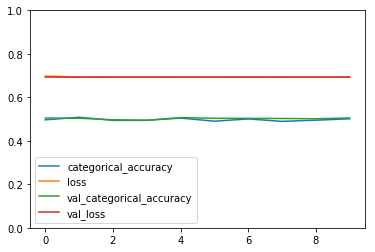

In [13]:
pd.DataFrame(history.history).plot(ylim=[0,1])